In [220]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [221]:
%cd DeepLearning_Financial

[Errno 2] No such file or directory: 'DeepLearning_Financial'
/data/home/dsvm_server_admin/notebooks/fastai/tesi/DeepLearning_Financial


In [222]:
## EXTERNAL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import yfinance
from pandas import Series
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, PredefinedSplit
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from IPython.display import display
import datetime
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import time
import os
import random 
from sklearn.datasets import make_regression
from torch import nn
import torch.nn.functional as F
from skorch import NeuralNetRegressor
from torch.nn.modules.loss import MSELoss
import tensorflow as tf
from tensorflow import keras
from skorch.dataset import CVSplit
from skorch import callbacks
import pickle
from sklearn.model_selection import train_test_split
from functools import partial
import skorch
import pywt
from sklearn import preprocessing
import joblib


##INTERNAL
from models import Autoencoder, waveletSmooth, SequenceDouble, SequenceDoubleAtt, SequenceAtt
from utils import prepare_data_lstm, ExampleDataset, save_checkpoint, evaluate_lstm, backtest
from testing import *
from sa_tools import *
from test_models import *

## Creazione dei dataset

In [337]:
indices = ['^GSPC', '^DJI', '^HSI', '^N225', 'ASHR','^NSEI']
feature_sets = ['open', 'ohlcv', 'ext']
start_date="2000-01-01"
end_date="2018-12-31"

datasets= load('^GSCP')



for model_name, feature_set in [('lstm_moro', 'open'), ('lstm_sa', 'ext_sa'), ('lstm_att', 'ohlcv')]:
    for index_name in ['^GSPC']:
        for split_period in ['2000-09-19_2005-04-15']:
            model_full_name = "{}_{}_{}".format(model_name, index_name, split_period)
            model = load(model_full_name)

            split = model.train_split
            train_dates, valid_dates = list(model.train_split.cv.split(datasets[index_name]["target"]))[0]

            sa=None
            ld=True
            fset= feature_set
            if(feature_set is 'ext_sa'):
                fset='ext'
                sa = "sa_{}_{}".format(index, split_period)
            x, y, x_train, x_val, x_scaler, y_train, y_val, y_scaler = get_dataset_train(datasets=datasets, feature_set=fset, train_dates=train_dates, val_dates=val_dates, index=index, sa=sa, ld=ld)

            n_days=10
            x_batch = days_group(x, n_days=n_days)
            y_batch = y[n_days:]
            serie = x_batch
            train_dates_s = train_dates[n_days:].copy()
            val_dates_s = val_dates.copy()

            splitted = np.split(serie, [len(train_dates_s)])
            l1, l2 = len(splitted[0]), len(splitted[1])
            train_s = PredefinedSplit(np.concatenate((np.ones(l1)*-1,np.ones(l2))))
            train_split =  CVSplit(cv=train_s, stratified=False, random_state=None)  
            train_dates_t, val_dates_t = list(train_s.split(serie))[0]

            train_dates_s, valid_dates_s =datasets[index_name]["target"].index[train_dates_t], datasets[index_name]["target"].index[val_dates_t]
            opn_test = datasets[index_name]["original"]["Open"].loc[valid_dates_s]
            close_test = datasets[index_name]["target"].loc[valid_dates_s]

            x_test_batch = x_batch[val_dates_t]


            pred = model.predict(x_test_batch).squeeze()
            pred_unsc = pd.Series(y_scaler.inverse_transform(pred), index=close_test.index)

            roi_test = partial(roi,opn=opn_val)
            mape = (abs(close_test - pred_unsc)/close_test).mean()
            mspe = (((close_test - pred_unsc)/close_test)**2).mean()
            acc = 1 - mape
            roi_score = roi_test(close_test, pred_unsc)
            r2_score = sklearn.metrics.r2_score(close_test, pred_unsc)
                                                
            print("\n----{}----".format(model_full_name))
            print("mape: %.4f\nmspe: %.4f\nacc: %.4f\nR2: %.4f\nroi: %.4f"% (mape, mspe, acc, r2_score, roi_score))
            print("valid_loss: %.4f" % (model.history[-1]["valid_loss"]))
            print("epochs: {}".format(len(model.history)))


----lstm_moro_^GSPC_2000-09-19_2005-04-15----
mape: 0.8839
mspe: 1.0097
acc: 0.1161
R2: -27.6190
roi: -0.0106
valid_loss: 0.0283
epochs: 813

----lstm_sa_^GSPC_2000-09-19_2005-04-15----
mape: 0.9920
mspe: 1.1201
acc: 0.0080
R2: -33.3812
roi: -0.0106
valid_loss: 0.0675
epochs: 443

----lstm_att_^GSPC_2000-09-19_2005-04-15----
mape: 0.1626
mspe: 0.0554
acc: 0.8374
R2: -0.2480
roi: 0.2407
valid_loss: 0.1305
epochs: 20


In [322]:
x_test_batch.shape

(2008, 5, 10)

In [331]:
pd.Serie(x_test_batch['r2'])

AttributeError: module 'pandas' has no attribute 'Serie'

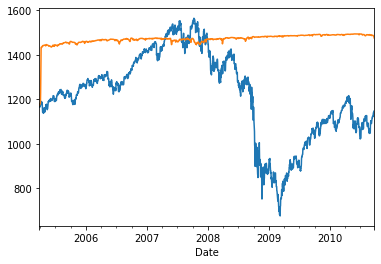

In [332]:
close_test.plot()
pred_unsc.plot()

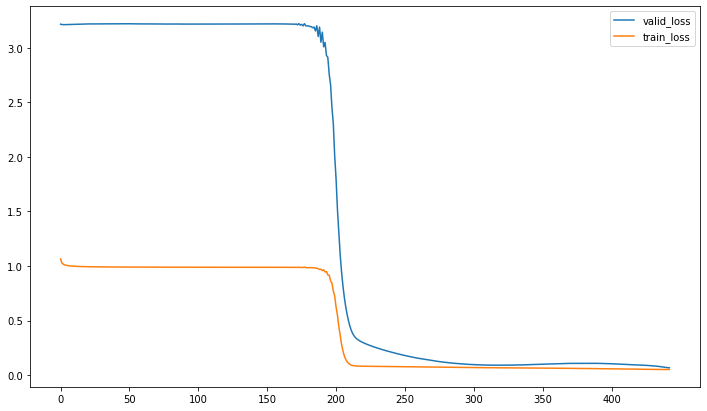

In [320]:
lstm = model
valid_losses = lstm.history[:, 'valid_loss']
train_losses = lstm.history[:, 'train_loss']
plt.figure(figsize=(12,7))
plt.plot(valid_losses, label='valid_loss')
plt.plot(train_losses, label='train_loss')
plt.xticks(np.arange(len(valid_losses)+1, step=50))
plt.legend()